In [20]:
using LinearAlgebra
using Statistics
using PyPlot

In [34]:
function rand_potential(nx, ny)
    rg = 1:3
    return rand(rg, ny, nx)
end

function dpre_bad(y0, V)
    m, n = size(V)
    infty = 2^32-1
    Jy = 1
    s = fill(infty, m, n)
    s_diff = fill(0, m, n)

    s[y0, 1] = V[y0, 1]
    
    for i in 2:n
        for j in 1:m
            l = argmin([s[k, i-1] + abs(k-j) for k in 1:m])
            s[j, i] = s[l, i-1] + abs(l-j) + V[j, i]
        end
    end
    
    return s
end

function dpre(y0, V)
    m, n = size(V)
    infty = 2^32-1
    Jy = 1
    E = fill(infty, m, n)
    Ep = fill(infty, m, n)
    Epp = fill(infty, m, n)
    
    E[y0, 1] = V[y0, 1]
    Ep[y0, 1] = 0
    Epp[y0, 1] = 0
    
    @inbounds for i in 2:n
        Epp[1, i] = E[1, i-1]
        for j in 1:1:m-1
            Epp[j+1, i] = min(E[j+1, i-1], Epp[j, i] + Jy)
        end
        Ep[m, i] = Epp[m, i]
        for j in (m-1):(-1):1
            Ep[j, i] = min(Epp[j, i], Ep[j+1, i] + Jy)
        end
        for j in 1:m
            E[j, i] = Ep[j, i] + V[j, i]
        end
    end
    return E
end


function dpre_f_rms(m, n, n_sample)
    fs = [minimum(dpre(1, rand_potential(n, m)), dims=1)[1,:] for _ in 1:n_sample]
    return std(fs)
end

function dpre_z_rms(m, n, n_sample)
    fs = [[a[1] for a in argmin(dpre(1, rand_potential(n, m)), dims=1)[1, :]] for _ in 1:n_sample]
    return std(fs)
end

dpre_z_rms (generic function with 1 method)

In [28]:
m, n = 8, 10
kk = 100
for _ in 1:kk
    V = rand_potential(n, m)
    y0 = rand(1:m)
    a = dpre(y0, V)
    b = dpre_bad(y0, V)
    @assert a==b
end

In [25]:
a

4×4 Array{Int64,2}:
 4294967295  7  6   9
          3  4  7  10
 4294967295  5  8  11
 4294967295  7  8  11

In [35]:
m, n = 256, 512
n_sample = 1000

a = dpre_f_rms(m, n, n_sample)
b = dpre_z_rms(m, n, n_sample)

512-element Array{Float64,1}:
  0.0
  0.31675121362250996
  0.5384142363365649
  0.6769410973262425
  0.8629279486982853
  1.0381241263460268
  1.1295640375449838
  1.241839831124039
  1.361797890104656
  1.4742470635563163
  1.596236815755097
  1.6790980824151962
  1.79822373708296
  ⋮
 19.36306544179677
 19.258315651212115
 19.515857775273524
 19.38069005859046
 19.26754881756984
 19.821919899659274
 19.478984106513916
 19.95081078179157
 20.112792158435077
 20.01333049238425
 19.939392025695142
 20.00798316648607

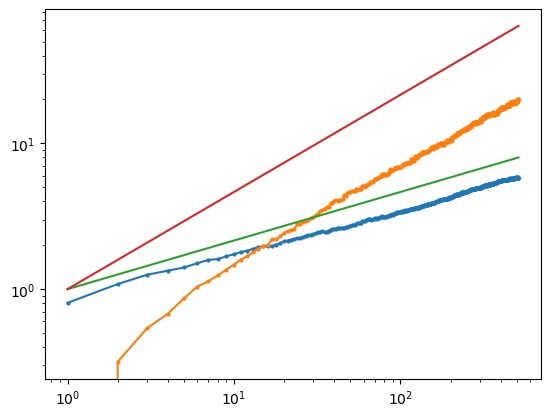

In [36]:
x = 1:n

plot(x, a, "-o", ms=2)
plot(x, b, "-o", ms=2)

plot(x, x.^(1/3))
plot(x, x.^(2/3))

xscale("log")
yscale("log")

In [80]:
A_list = 64:64:512
n_step = 32
step_size = 4
n_average = 1024
result = MI_sim(n_step, step_size, A_list, n_average)

32×8 Array{Float64,2}:
 2.43359  2.03809  2.13281   2.32227   2.72559   2.57324   2.94434   3.17773
 4.5127   4.4707   4.69629   5.02441   5.24902   5.31445   5.3291    5.21289
 5.19238  6.20508  6.47363   6.93555   6.9375    7.20898   7.03809   6.92285
 5.27344  7.14844  8.08496   8.74023   8.48242   8.69043   8.45312   8.18945
 5.28125  7.47363  8.96973   9.84277   9.70898  10.0801    9.98535   9.77441
 5.28125  7.55469  9.42969  10.6875   10.8945   11.3857   11.2725   11.0479
 5.28125  7.56348  9.57715  11.0527   11.5244   12.21     12.2178   12.1074
 5.28125  7.56543  9.62695  11.2588   11.957    12.9277   13.1152   13.1631
 5.28125  7.56543  9.64453  11.3428   12.1641   13.2666   13.6152   13.7354
 5.28125  7.56543  9.64648  11.3604   12.2402   13.4619   13.9434   14.166
 5.28125  7.56543  9.64648  11.3613   12.3047   13.5879   14.1699   14.5195
 5.28125  7.56543  9.64648  11.3652   12.3271   13.6436   14.2939   14.7148
 5.28125  7.56543  9.64648  11.3652   12.3271   13.6465   14.

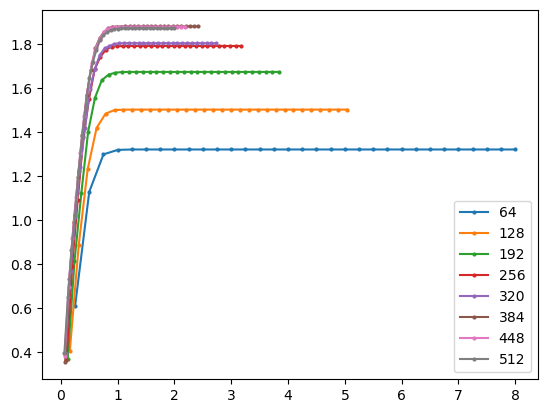

PyObject <matplotlib.legend.Legend object at 0x0000000007F6C9D0>

In [84]:
fg, ax = subplots(1)
for (i, A) in enumerate(A_list)
    x = (1:n_step) .* step_size ./ A^(2/3)
    y = result[:, i] ./ A^(1/3)
    ax.plot(x, y, "-o", ms=2, label=A)
end
ax.legend()

In [105]:
A_list = 1:512
n_step = 1
step_size = 512
n_average = 4096

s_top = MI_sim(n_step, step_size, A_list, n_average)

1×512 Array{Float64,2}:
 -0.00927734  0.00756836  0.0778809  …  15.4204  15.4163  15.5461  15.6055

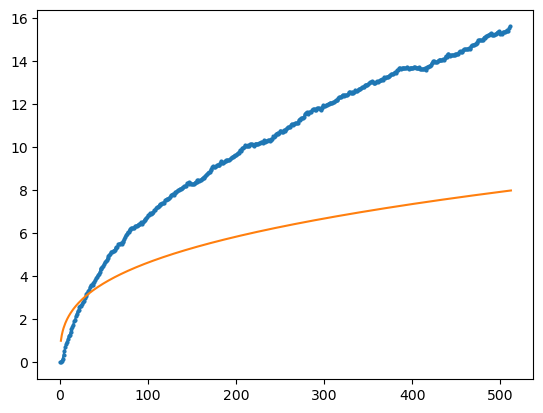

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000048DACA60>

In [111]:
plot(s_top[1,:], ms=2, "-o")
# xscale("log")
# yscale("log")

x = 1:512
plot(x, x.^0.333)

In [93]:
s_top

1×512 Array{Float64,2}:
 0.0175781  -0.0117188  0.0478516  …  15.5625  15.6494  15.6182  15.6992

In [2]:
using LinearAlgebra

In [13]:
X = [0 1; 1 0]
Y = [0 -1im; 1im 0]
Z = [1 0; 0 -1]
II = [1 0; 0 1];

In [17]:
rand_ps(n) = n==1 ? rand([II, X, Z]) : kron([rand([II, X , Z]) for _ in 1:n]...)
rand_prod_ps_proj(m, n) = *([I - rand_ps(n) for _ in 1:m]...)

rand_prod_ps_proj (generic function with 1 method)

In [18]:
m, n = 30,5
tr(rand_prod_ps_proj(m, n))

0

In [19]:
po = 0
ne = 0

for _ in 1:1000
    tmp = real(tr(rand_prod_ps_proj(m, n)))
    (tmp < 0) && (ne += 1)
    (tmp > 0) && (po += 1)
end
po, ne, 1000-po-ne

(137, 161, 702)